# Guppy Demo

This demo notebook gives an overview of currently implemented Guppy features.

In [1]:
import sys
sys.path.append("..")

from guppylang.hugr.hugr import Hugr
from guppylang.compiler import GuppyModule, guppy
from typing import Callable

# TODO: Disabled while we port guppy to use the hugr library
#from guppylang.hugr.visualise import hugr_to_graphviz
#setattr(
#    Hugr,
#    "_repr_svg_",
#    lambda self: hugr_to_graphviz(self)._repr_svg_(),
#)

## Intro

To get started, you can use the `@guppy` decorator to compile a single function without having to declare a module:

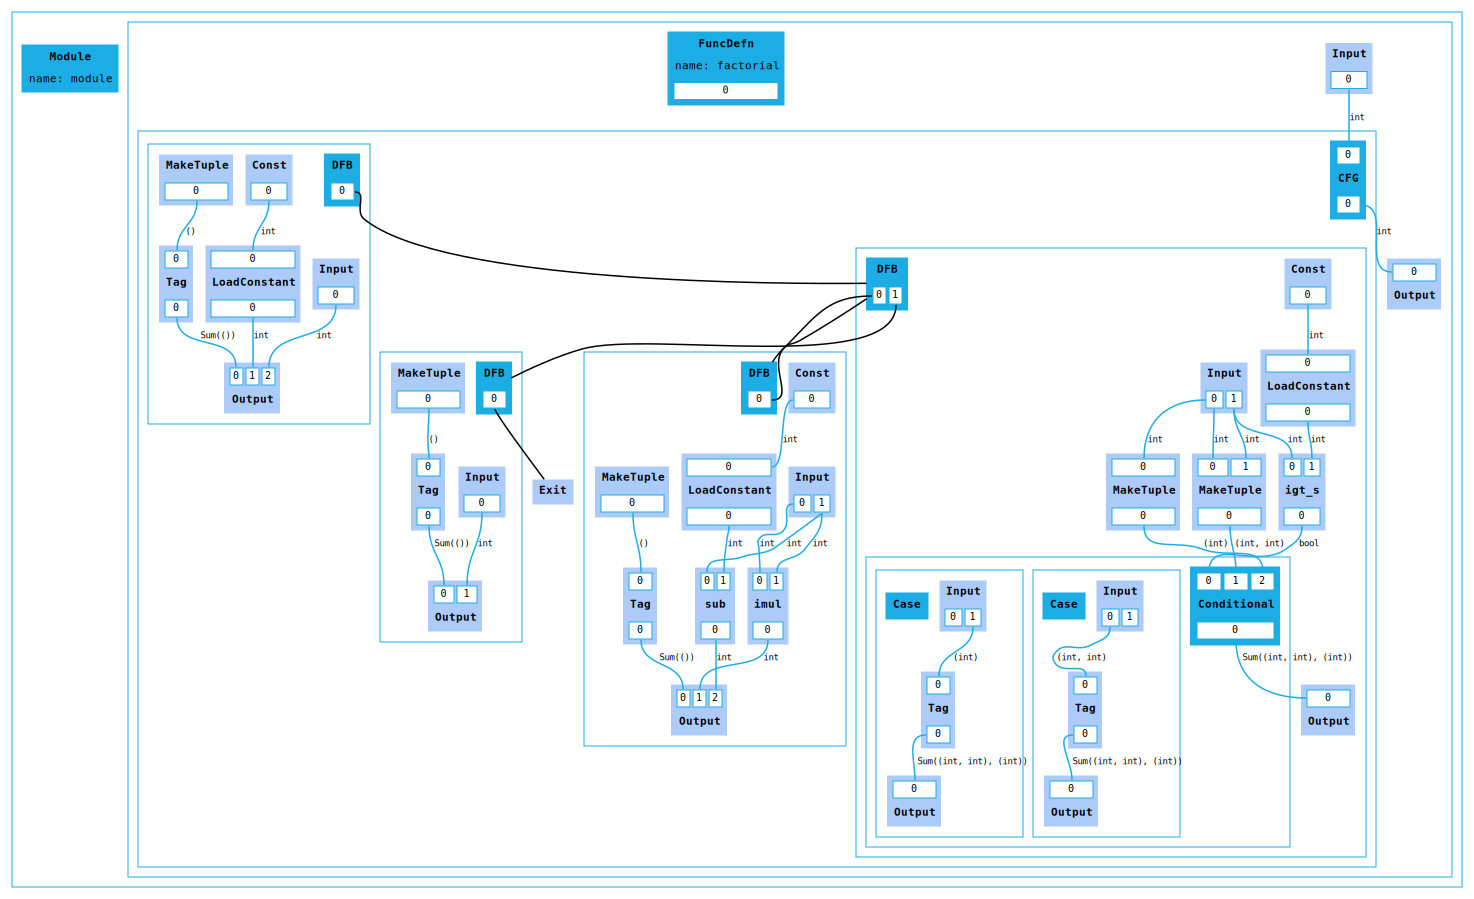

In [2]:
@guppy
def factorial(x: int) -> int:
    acc = 1
    while x > 0:
        acc *= x
        x -= 1
    return acc

factorial

Guppy can handle arbitrary Python control flow involving `if`, `while`, `continue`, `break`, and `return`. Many Python functions should be directly compilable. The main difference compared to regular Python is that Guppy functions must obey the following key rule to be compilable:

> **When a variable is used, it must be defined on any control flow path leading to this point and have the same type on all of those paths.**

Importantly, this only matters if a variable is used. For example, the following code is fine:

In [3]:
@guppy
def no_usage(x: int) -> int:
    if x > 0:
        a = 10
    else:
        a = True
    return x

However, if we use `a` then compilation will fail:

In [4]:
@guppy
def bad_fun(x: int) -> int:
    if x > 0:
        a = 10
    else:
        a = True
    return a

Guppy compilation failed. Error in file /var/folders/tw/395bz2tx0nv7wnltsw_zk7740000gn/T/ipykernel_47481/219269089.py:7

5:    else:
6:        a = True
7:    return a
             ^
GuppyError: Variable `a` can refer to different types: `int` (at 4:8) vs `bool` (at 6:8)


## Recursion

Guppy functions support recursion:

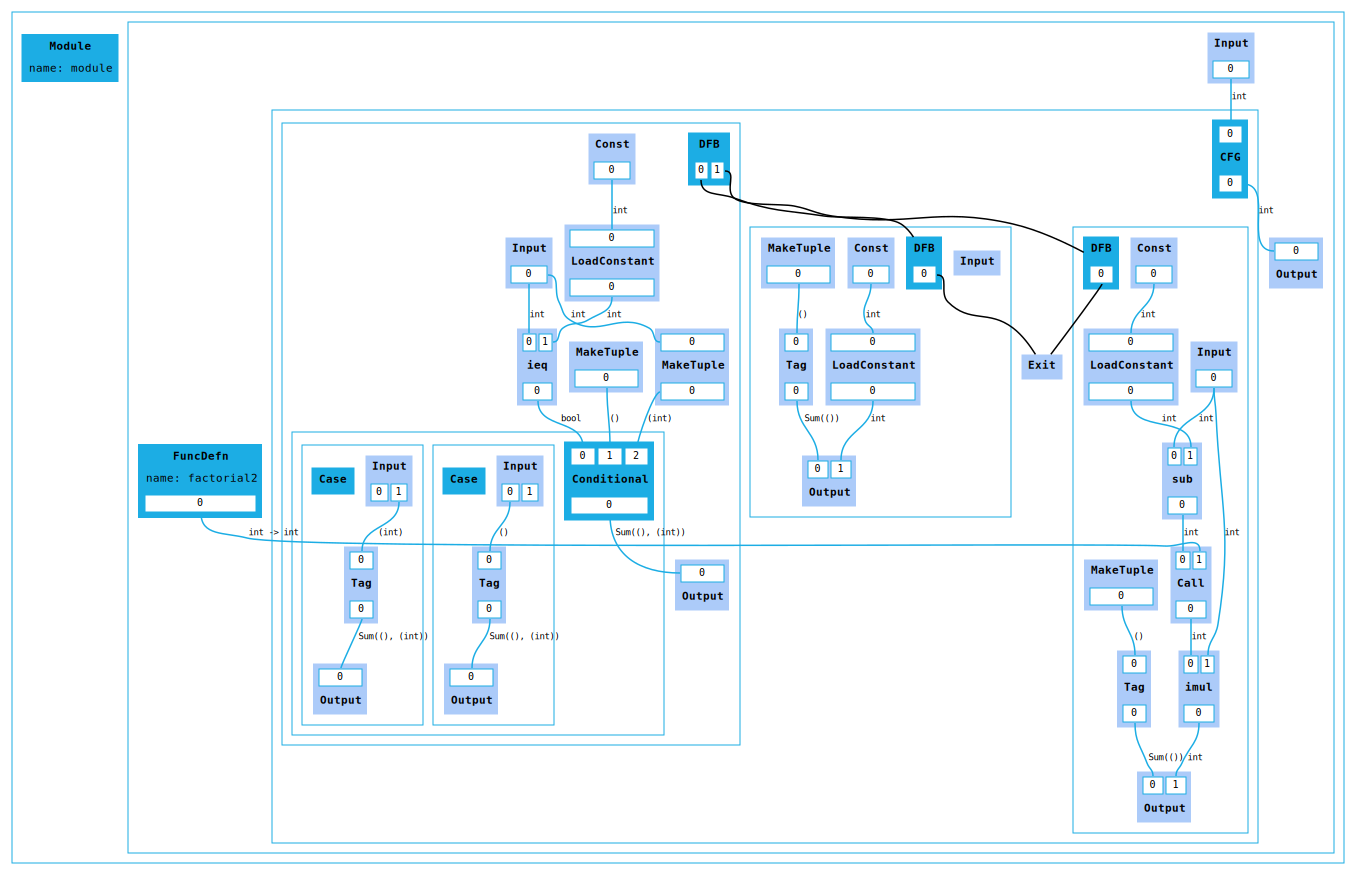

In [5]:
@guppy
def factorial2(x: int) -> int:
    if x == 0:
        return 1
    return factorial2(x-1) * x

factorial2

## Arithmetic

Guppy supports all arithmetic operations and has implicit `int` to `float` coercion when applying those operations:

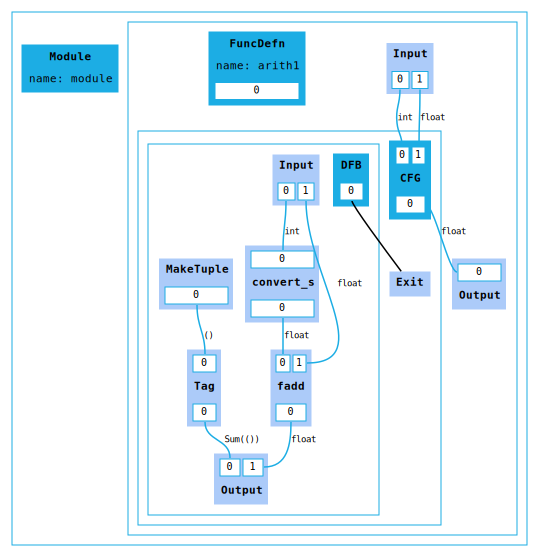

In [6]:
@guppy
def arith1(x: int, y: float) -> float:
    return x + y

arith1

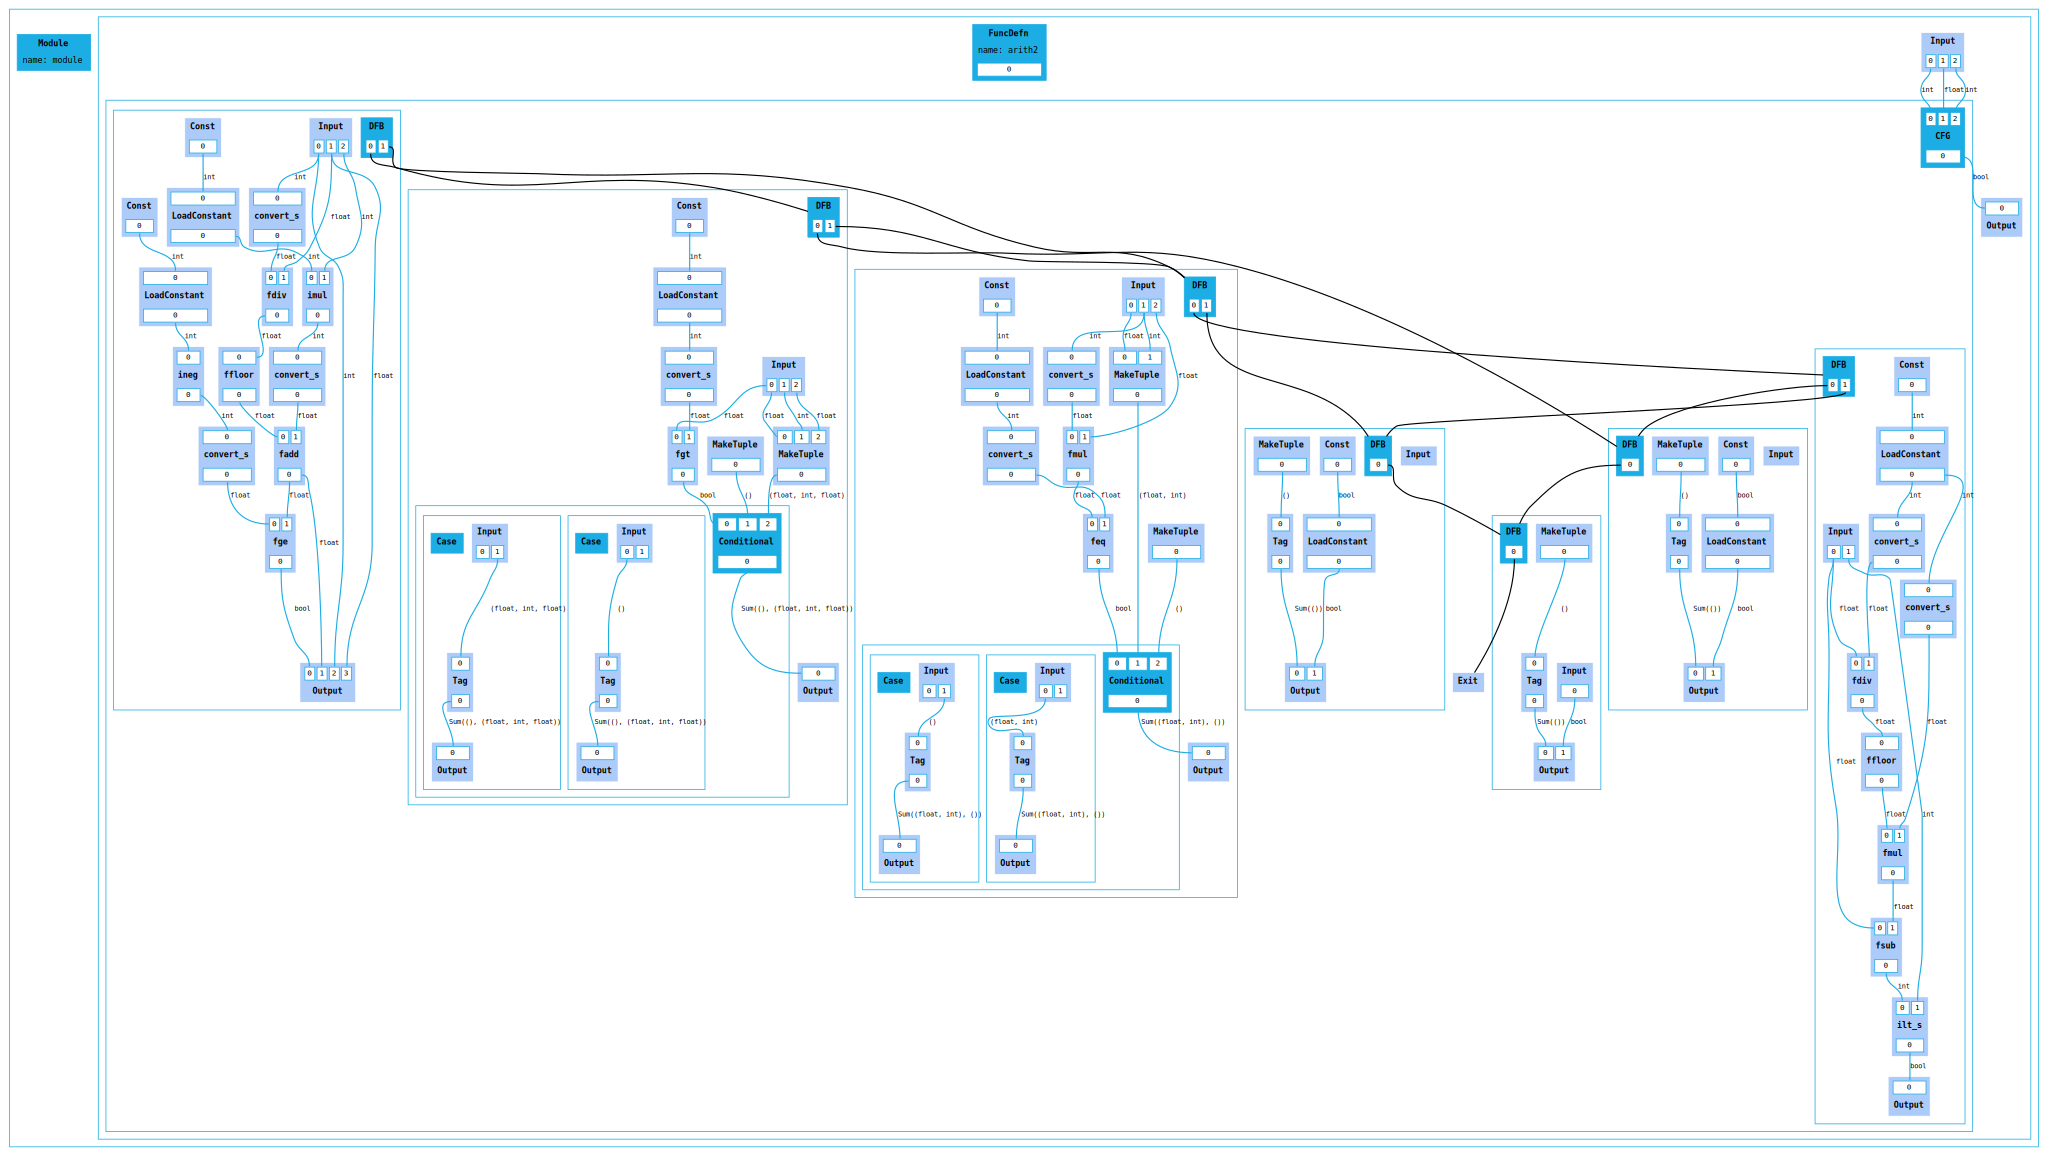

In [7]:
@guppy
def arith2(x: int, y: float, z: int) -> bool:
    a = x//y + 3*z
    b = -8 >= a > 5 or (x*y == 0 and a % 3 < x)
    return b

arith2

## Nested Functions and Higher-Order

Guppy supports nested function definitions with variables captured from outer scopes.

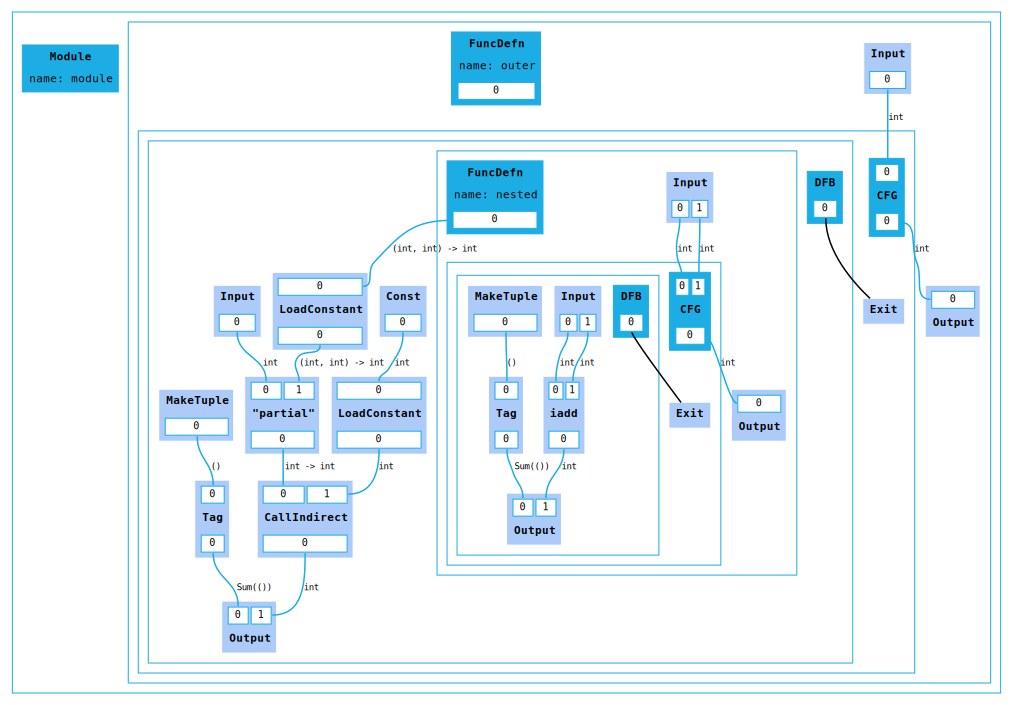

In [8]:
@guppy
def outer(x: int) -> int:
    def nested(y: int) -> int:
        return x + y
    return nested(42)

outer

However, similar to regular Python, variables from enclosing functions scopes may not be modified. Python's `global` and `nonlocal` statements are not supported by Guppy.

In [9]:
@guppy
def outer(x: int) -> int:
    def nested() -> None:
        x += 1
    nested()
    return x

Guppy compilation failed. Error in file /var/folders/tw/395bz2tx0nv7wnltsw_zk7740000gn/T/ipykernel_47481/2923744560.py:4

2:    def outer(x: int) -> int:
3:        def nested() -> None:
4:            x += 1
              ^^^^^^
GuppyError: Variable `x` defined in an outer scope (at 2:10) may not be assigned to


## Modules

In order to use call other Guppy functions, they must be placed in the same module:

In [10]:
module = GuppyModule("mutual_rec_module")

@guppy(module)
def is_even(x: int) -> bool:
    if x == 0:
        return True
    return is_odd(x-1)

@guppy(module)
def is_odd(x: int) -> bool:
    if x == 0:
        return False
    return is_even(x-1)

Compilation of modules needs to be triggered separately, after all functions are defined (in order to support mutual recursion):

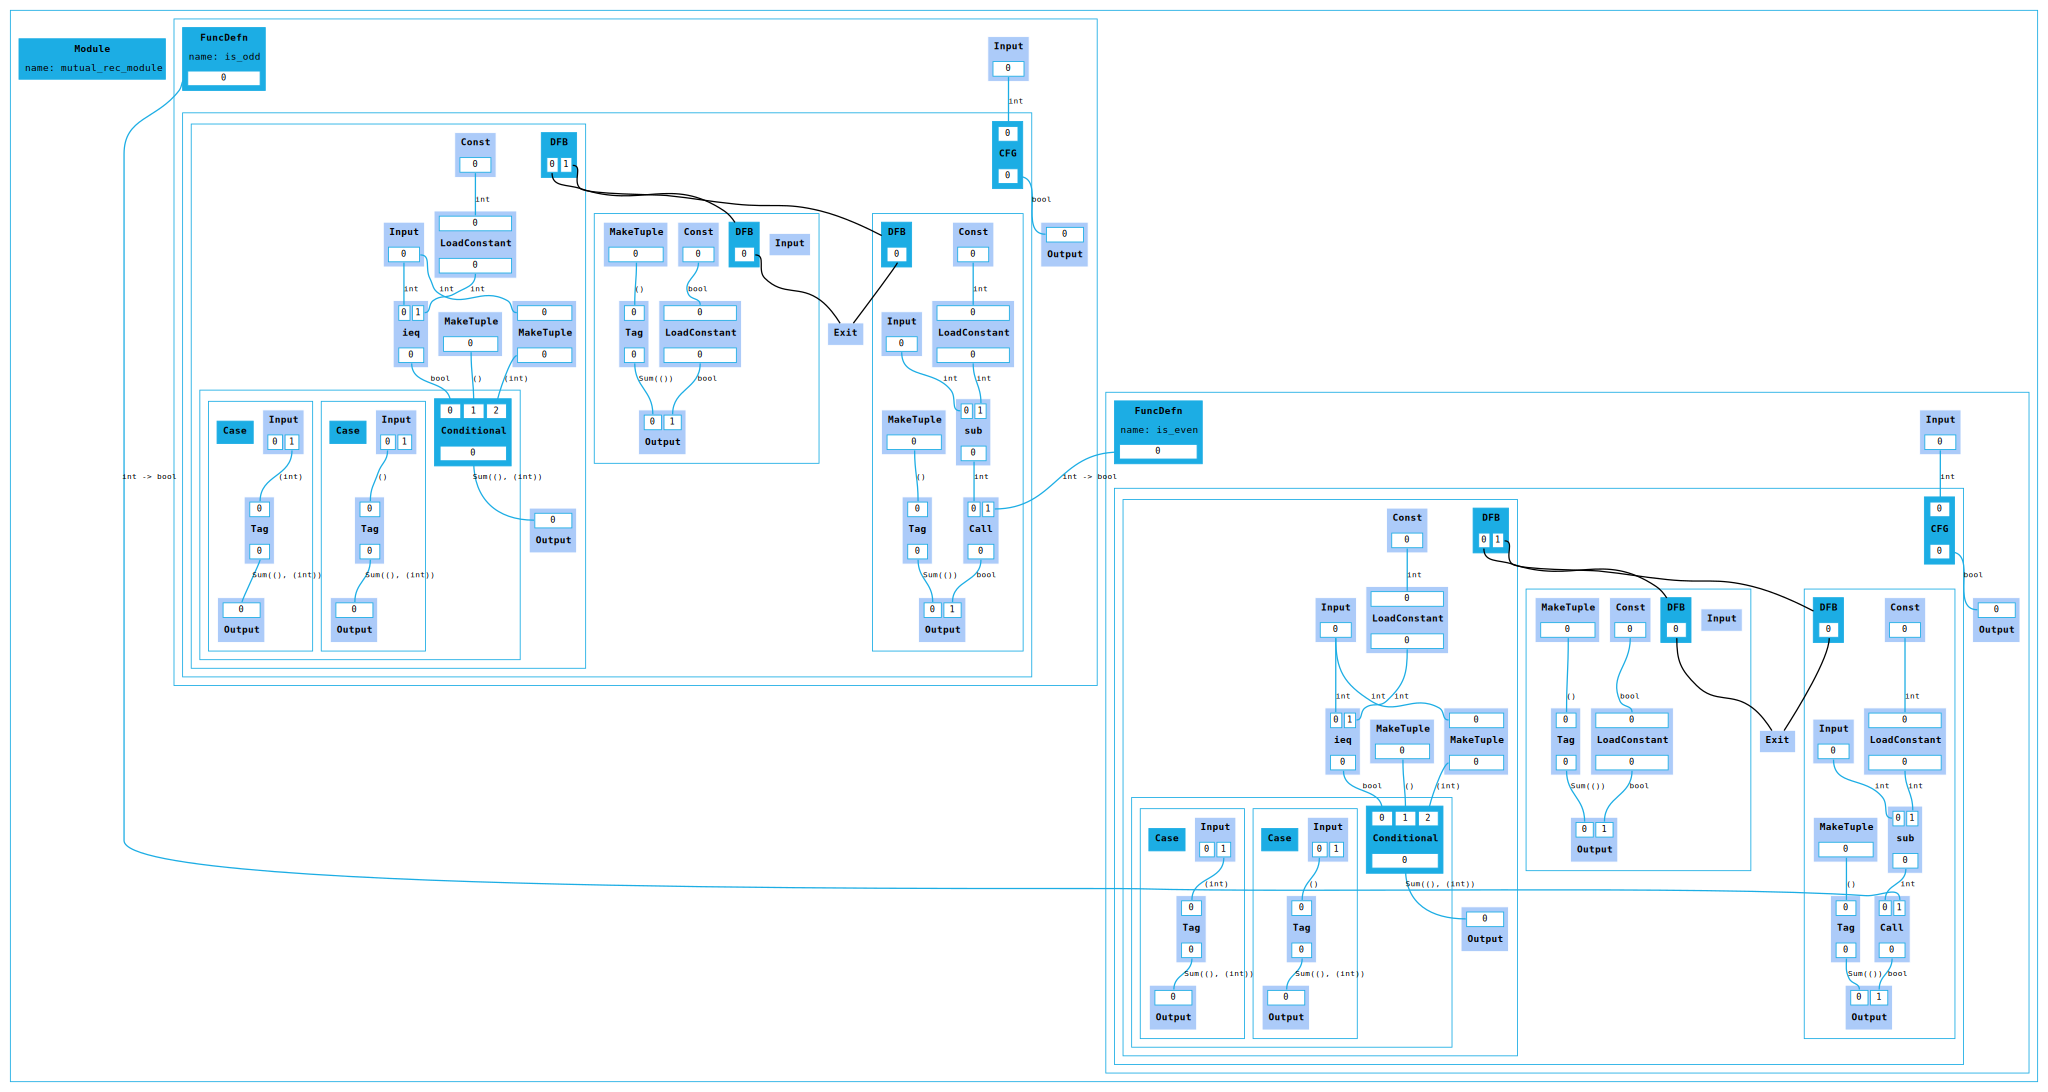

In [11]:
module.compile()

## Higher-Order

Functions can be used as higher-order values.

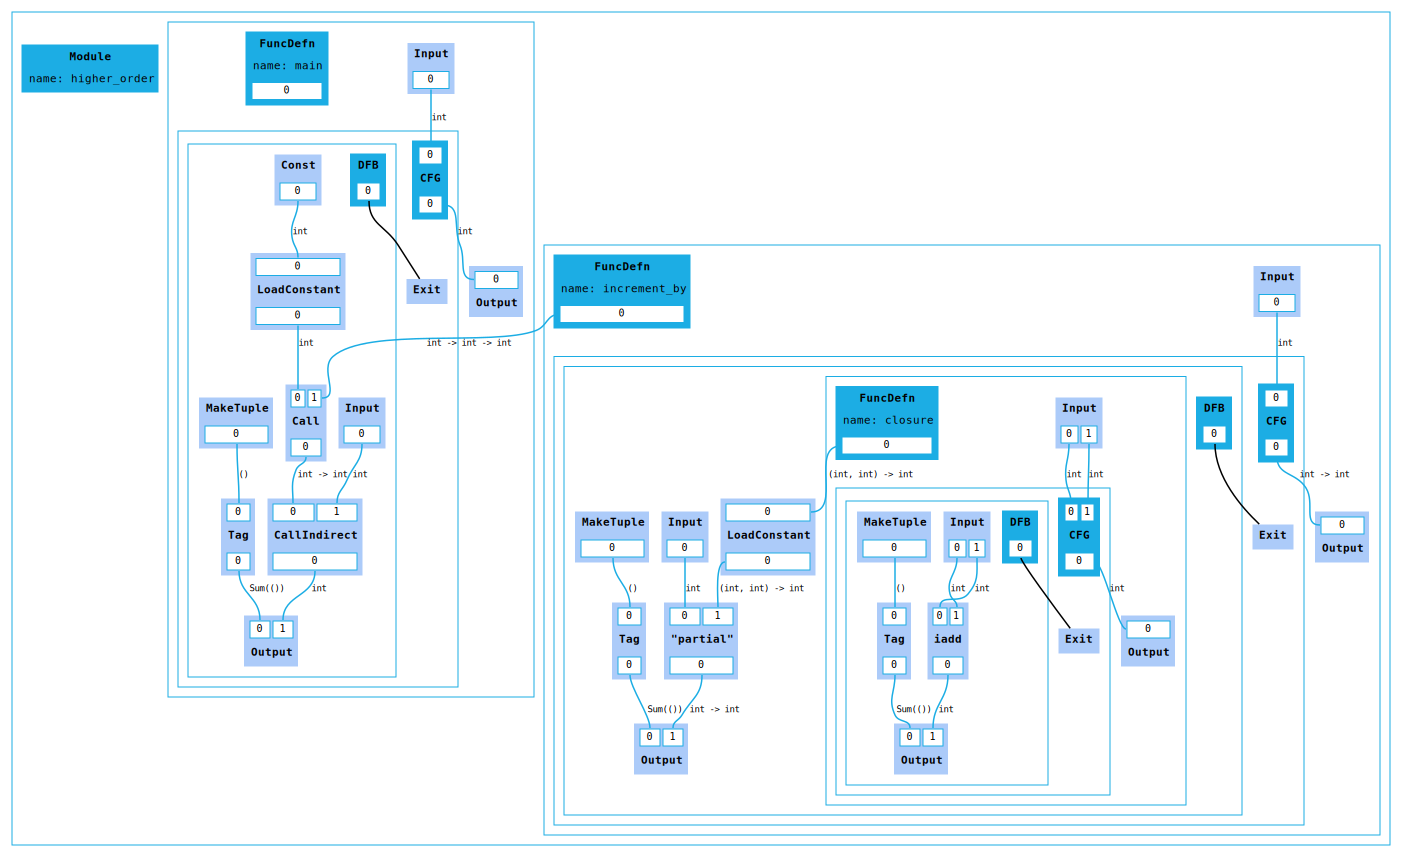

In [12]:
module = GuppyModule("higher_order")

@guppy(module)
def increment_by(inc: int) -> Callable[[int], int]:
    def closure(x: int) -> int:
        return x + inc
    return closure

@guppy(module)
def main(x: int) -> int:
    inc5 = increment_by(5)
    return inc5(x)

module.compile()

# Quantum Programs

In order to write quantum programs, the quantum extension needs to be loaded.

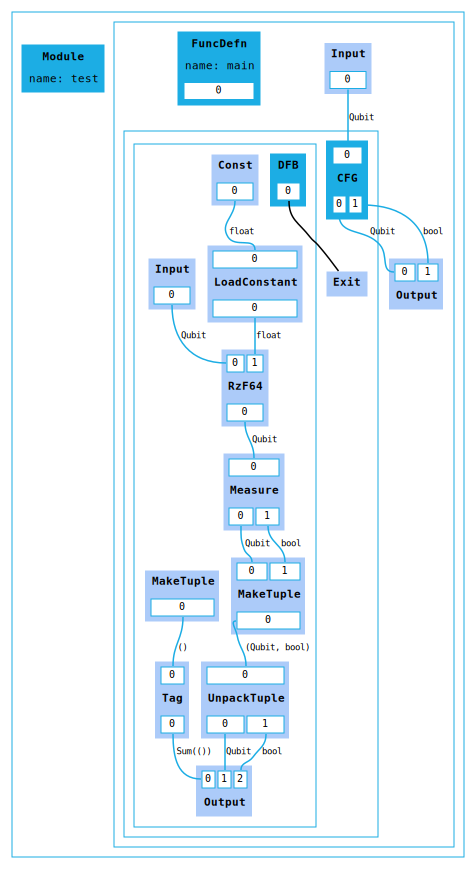

In [13]:
import guppylang.prelude.quantum as quantum
from guppylang.prelude.quantum import qubit

module = GuppyModule("test")
module.load(quantum)

@guppy(module)
def main(q: qubit) -> tuple[qubit, bool]:
    q = rz(q, 3.1415)
    return measure(q)

module.compile()

Below is a more involved example with control flow, implementing the $V_3 = \exp(i*\arctan(2)*Z)$ gate via the repeat-until-success algorithm from arXiv:1311.1074 (Fig 1c).

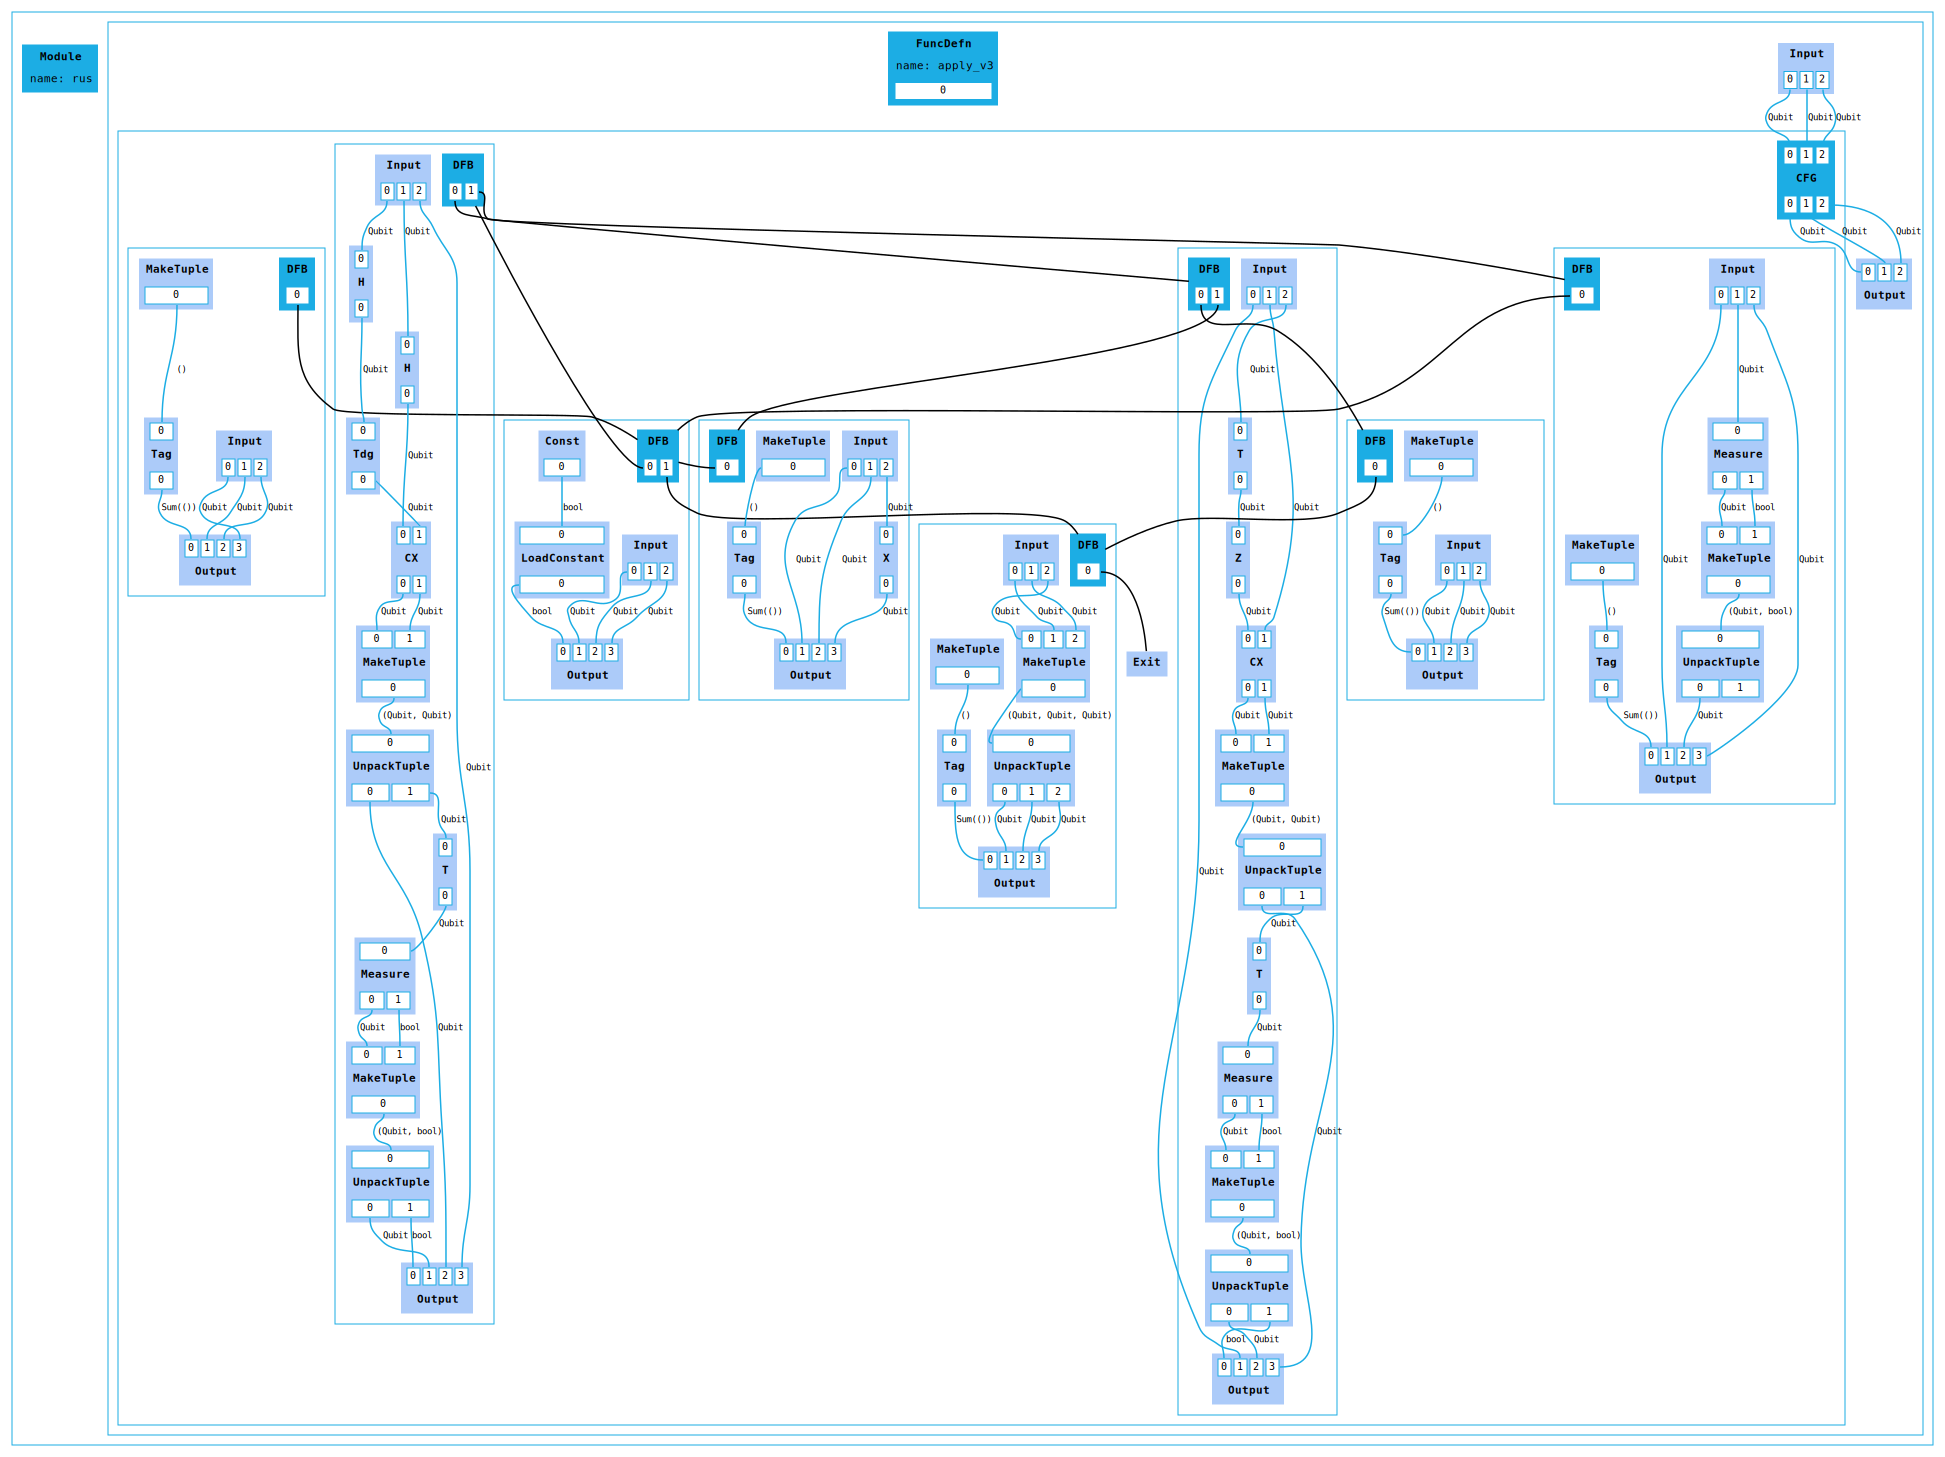

In [14]:
module = GuppyModule("rus")
module.load(quantum)

@guppy(module)
def apply_v3(q: qubit, a: qubit, b: qubit) -> tuple[qubit, qubit, qubit]:
    while True:
        a, b = h(a), h(b)

        b, a = cx(b, tdg(a))
        a = t(a)
        a, res = measure(a)
        if not res:
            b, _ = measure(b)  # Discard b
            continue

        q, b = cx(z(t(q)), b)
        b = t(b)
        b, res = measure(b)
        if res:
            break

        q = x(q)  # Apply correction
    
    return q, a, b

module.compile()